# Higgs Challenge - Jan

* [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

## Initialisation

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas
import pandas as pd
import numpy
import numpy as np

import root_numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

Welcome to ROOTaaS 6.06/04


### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

File `public_train_10000.root' already there; not retrieving.
File `public_train_100000.root' already there; not retrieving.
File `public_test.root' already there; not retrieving.


### Read the training files and the test file
* `data` holds the small training data set
* `full_data` holds the full training data set
* `test` holds the test data set

In [6]:
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
full_data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

data.head(2)

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559


## Utility functions for feature engineering

In [7]:
def dphi(phi1, phi2):
    "Return the angular difference in the range [-pi,pi)"
    dphi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return dphi

def dr(eta1, eta2, phi1, phi2):
    "Return the eta-phi distance"
    return np.sqrt((eta1-eta2)**2 + dphi(phi1,phi2)**2)

## Define training features

### Existing features

In [9]:
features = list(set(data.columns) - {'event_id', 'target'})
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

# a list of all proper objects and all objects + MET
real_objects = ['lepton', 'jet1', 'jet2', 'jet3', 'jet4']
objects = real_objects + ['mem']



### Define additional features

In [82]:
def add_features(data):
    data['ht'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt']
    data['meff'] = data['jet1_pt'] + data['jet2_pt'] + data['jet3_pt'] + data['jet4_pt'] + data['lepton_pt'] + data['mem_pt']
    data['rt'] = data['meff'] / data['m_wwbb']
    data['delta_m'] = np.abs(data['m_jjj'] - data['m_jlv'])
    
    variables = ['ht', 'meff', 'rt', 'delta_m']
    
    data['dr_j12'] = dr(data['jet1_eta'], data['jet2_eta'], data['jet1_phi'], data['jet2_phi'])
    data['dr_j34'] = dr(data['jet3_eta'], data['jet4_eta'], data['jet3_phi'], data['jet4_phi'])
    
    variables += ['dr_j12', 'dr_j34']
    
    for i in [1,2,3,4]:
        data['dr_lj%d' % i] = dr(data['jet%d_eta' % i], data['lepton_eta'], data['jet%d_phi' % i], data['lepton_phi'])
        data['dphi_met_j%d' % i] = np.abs(dphi(data['mem_phi'], data['jet%d_phi' % i]))

        variables += ['dr_lj%d' % i, 'dphi_met_j%d' % i]
        
    data['max_dr_lj'] = np.maximum(np.maximum(data['dr_lj1'], data['dr_lj2']),
                                   np.maximum(data['dr_lj3'], data['dr_lj4']))
    data['min_dr_lj'] = np.minimum(np.minimum(data['dr_lj1'], data['dr_lj2']),
                                   np.minimum(data['dr_lj3'], data['dr_lj4']))   

    data['max_dphi_met_j'] = np.maximum(np.maximum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.maximum(data['dphi_met_j3'], data['dphi_met_j4']))
    data['min_dphi_met_j'] = np.minimum(np.minimum(data['dphi_met_j1'], data['dphi_met_j2']),
                                        np.minimum(data['dphi_met_j3'], data['dphi_met_j4']))

    variables += ['max_dr_lj', 'min_dr_lj', 'max_dphi_met_j', 'min_dphi_met_j']
    
    for obj in real_objects:
        data['%s_abs_eta' % obj] = np.abs(data['%s_eta' % obj])
        variables.append('%s_abs_eta' % obj)
        
        for obj2 in ['lepton']:
            if obj == obj2:
                continue
            
            dphi_name = "dphi_%s_%s" % (obj, obj2)
            deta_name = "deta_%s_%s" % (obj, obj2)
            
            data[dphi_name] = np.abs(dphi(data['%s_phi' % obj], data['%s_phi' % obj2]))
            data[deta_name] = np.abs(data['%s_eta' % obj] - data['%s_eta' % obj2])
            
            variables += [dphi_name, deta_name]
    
    return variables

new_features = add_features(data)
add_features(full_data)
add_features(test)

training_data, validation_data = train_test_split(data, random_state=11, train_size=0.8)
full_train, full_valid = train_test_split(full_data, random_state=11, train_size=0.9)

signal = data[data.target == 1]
background = data[data.target == 0]

## Feature distributions

### Utility plotting functions

In [77]:
hist_params = {'normed': True, 'bins': 50, 'alpha': 0.4,}# 'histtype': 'stepfilled'}

def plot_feature(feature):
    plot_range = numpy.percentile(data[feature], [1, 99])
    plt.hist(background[feature].values, range=plot_range, label="background", **hist_params)
    plt.hist(signal[feature].values, range=plot_range, label="signal", **hist_params)
    plt.legend(loc='best')
    plt.title(feature)
    
def plot_value(sig, bkg, title=""):
    sig_val = sig.values
    bkg_val = bkg.values
    
    min_sig, max_sig = numpy.percentile(sig_val, [1, 99])
    min_bkg, max_bkg = numpy.percentile(bkg_val, [1,99])
    
    plot_range = (min(min_sig, min_bkg), max(max_sig, max_bkg))

    plt.figure(figsize=(8, 5))
    plt.hist(bkg_val, range=plot_range, label='background', **hist_params)
    plt.hist(sig_val, range=plot_range, label='signal', **hist_params)
    plt.legend(loc='best')
    plt.title(title)
    
def figure_2d(x, y, *args, **kwargs):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("signal")
    plt.hist2d(signal[x], signal[y], *args, **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.subplot(1, 2, 2)
    plt.title("background")
    plt.hist2d(background[x], background[y], *args, **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

def plot_vars(var_list):
    n_cols = 3
    n_rows = len(var_list) // n_cols + 1
    
    plt.figure(figsize=(16, n_rows*5))
    
    for n, var in enumerate(var_list):
        plt.subplot(n_rows, n_cols, n+1)
        plot_feature(var)


### High level features and object p<sub>T</sub>

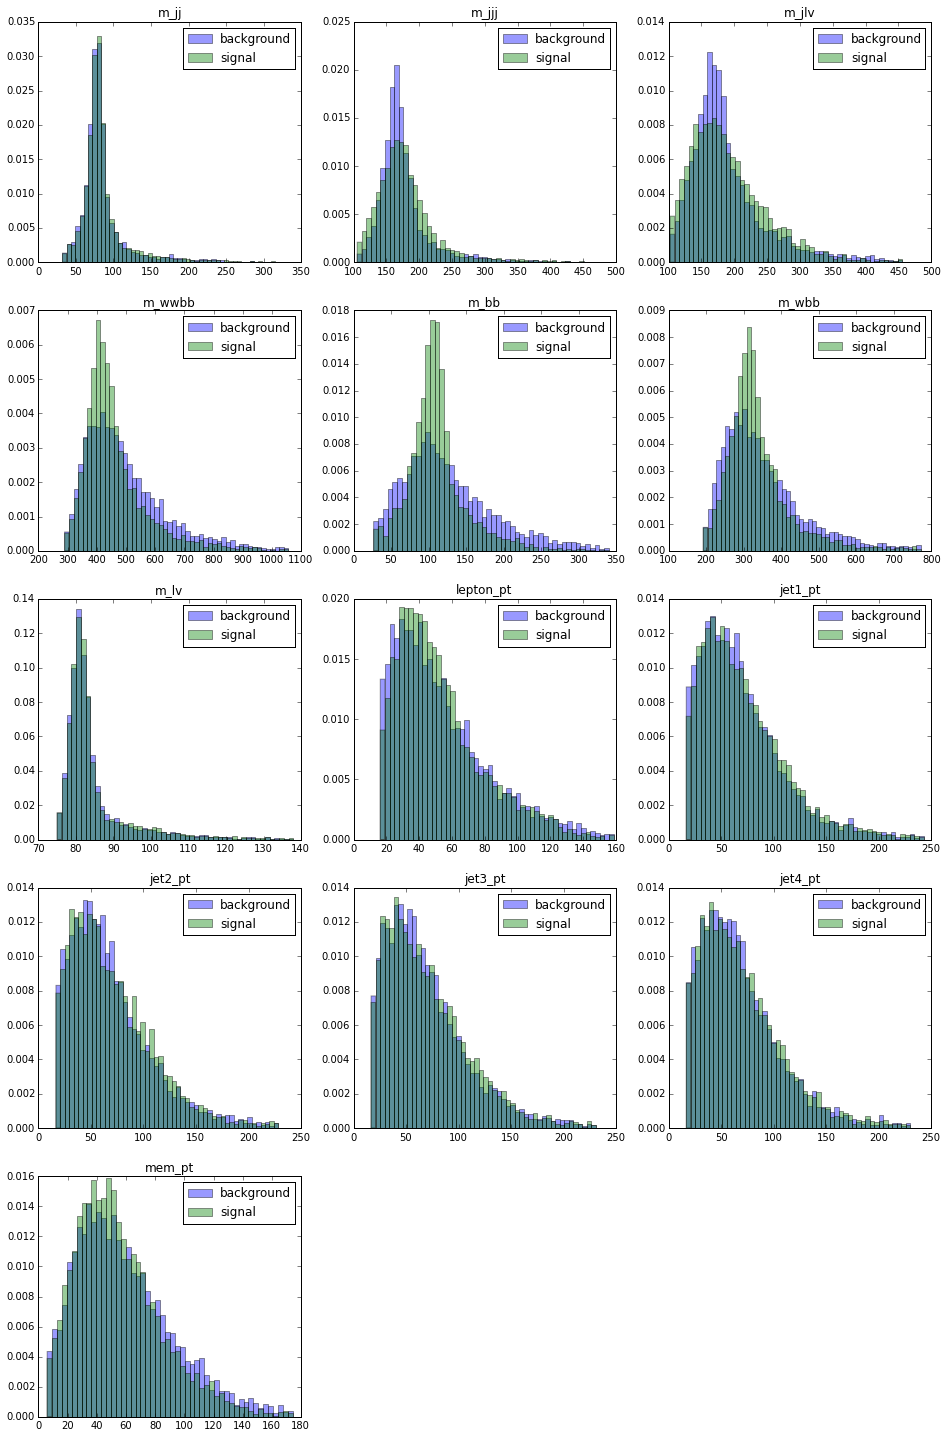

In [23]:
plot_vars(high_level_features + ["%s_pt" % obj for obj in objects])

### New features

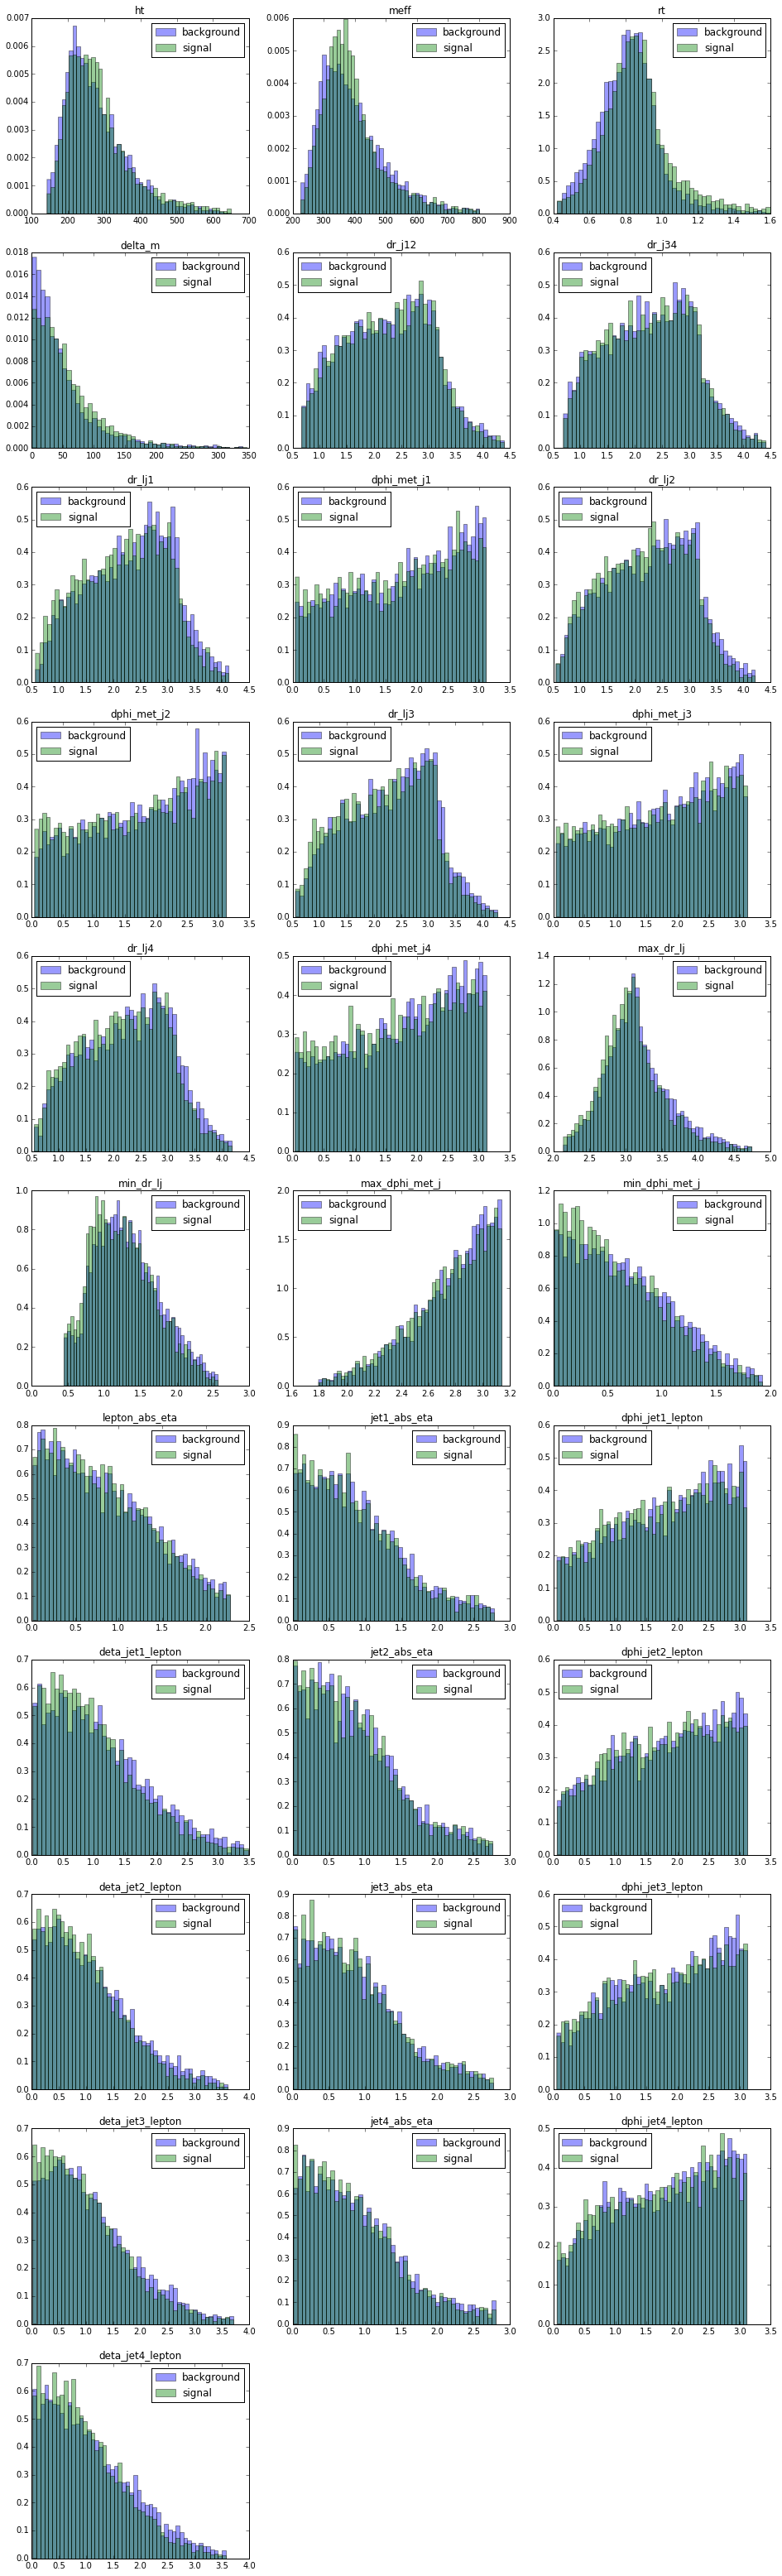

In [83]:
plot_vars(new_features)

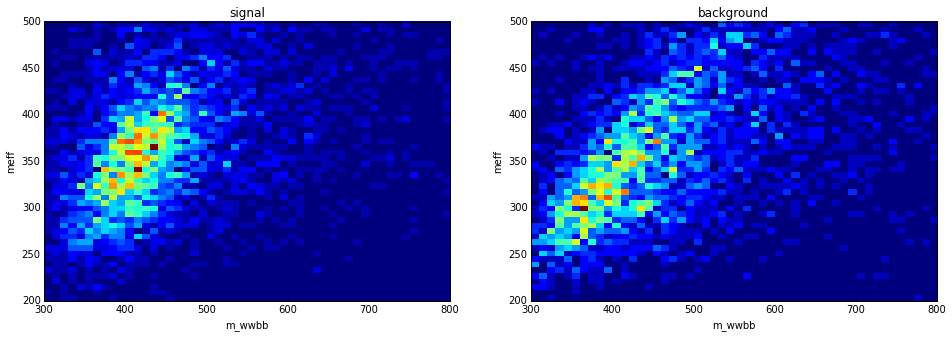

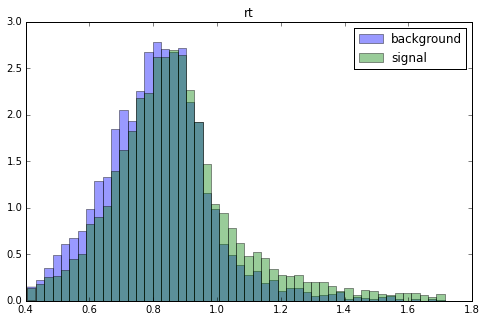

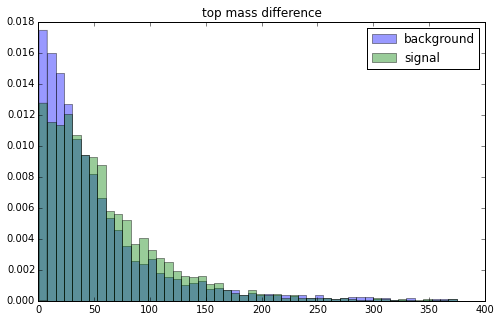

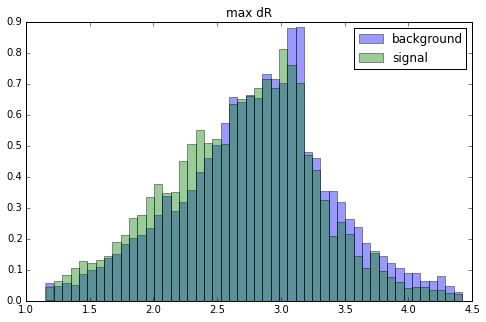

In [54]:
figure_2d("m_wwbb", "meff", range=((300,800), (200, 500)), bins=(50,50))

sig = signal
bkg = background
plot_value(sig["meff"] / sig["m_wwbb"], bkg["meff"] / bkg["m_wwbb"], "rt")
plot_value(np.abs(sig['m_jjj'] - sig['m_jlv']), np.abs(bkg['m_jjj'] - bkg['m_jlv']), "top mass difference")

plot_value(np.maximum(sig['dr_lj1'], sig['dr_lj2']), np.maximum(bkg['dr_lj1'], bkg['dr_lj2']), "max dR")

## Test area

## Cross validation

In [84]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

class CVEstimator(BaseEstimator):
    def __init__(self, cv, est_type, args={}):
        self.cv = cv
        self.estimator_type = est_type
        self.estimator_args = args
        
        self.estimators = [est_type(**args) for _ in xrange(self.cv)]
        
    def fit(self, x, y):
        skf = StratifiedKFold(y.copy(), self.cv)
        
        self.scores = []
        
        for i, train_test in enumerate(skf):
            est = self.estimators[i]
            train, test = train_test
            
            est.fit(x.iloc[train], y.iloc[train])
            
            pred = est.predict_proba(x.iloc[test])[:,1]
            score = roc_auc_score(y.iloc[test], pred)
            self.scores.append(score)
            
        # calculate feature importance
        score_norm = 1 / sum(self.scores)
        self.feature_importances_ = []
        
        for i in xrange(len(self.estimators[0].feature_importances_)):
            imp_sum = 0
            for j, est in enumerate(self.estimators):
                imp_sum += self.scores[j] * est.feature_importances_[i]
            
            self.feature_importances_.append(imp_sum * score_norm)
            
        
        return self
    
    def predict_proba(self, x):
        pred = None
        
        for est in self.estimators:
            this_pred = est.predict_proba(x)
            if pred is None:
                pred = this_pred
            else:
                pred += this_pred
        
        pred /= self.cv
        return pred

In [87]:
def check_classifier(features, clf, ranking=True, train=training_data, test=validation_data):
    clf.fit(train[features], train.target)
    pred = clf.predict_proba(test[features])
    print "AUC", roc_auc_score(test.target, pred[:,1])
    
    if ranking:
        for name, importance in sorted(zip(features, clf.feature_importances_), key=lambda x: x[1], reverse=True):
            print "%20s  %.4f" % (name, importance)

    return clf

In [89]:
selected_features = features + new_features

check_classifier(selected_features, CVEstimator(6, GradientBoostingClassifier, {'max_depth': 6}))

AUC 0.789224301872
                m_bb 0.0694624712835
               m_wbb 0.0353180732006
               m_jjj 0.0346513651772
              m_wwbb 0.0331673560896
           lepton_pt 0.0281876579057
               m_jlv 0.026414600725
              mem_pt 0.0259321836805
                  rt 0.0258013905198
                m_jj 0.0257995194579
                meff 0.0225416720173
    deta_jet2_lepton 0.0222464928905
                  ht 0.0201406677363
         dphi_met_j2 0.0198029642101
            jet3_phi 0.0189450241314
             delta_m 0.0189153761898
           min_dr_lj 0.018797553079
             jet4_pt 0.0176544548548
    deta_jet4_lepton 0.0175311824615
             jet1_pt 0.0173583825426
             mem_phi 0.0169789378235
    deta_jet1_lepton 0.0167156222997
      min_dphi_met_j 0.0165216565946
            jet4_phi 0.0162340491471
              dr_j34 0.0154248557883
         dphi_met_j3 0.0152639265828
            jet1_phi 0.0149954428765
    deta_jet3_lepton 

CVEstimator(args=None, cv=6, est_type=None)

## Prepare submission to kaggle

### Train final classifier over full dataset and evaluate on test sample

In [90]:
final_clf = check_classifier(selected_features, CVEstimator(6, GradientBoostingClassifier, {'max_depth': 6}),
                             train=full_train, test=full_valid)

test_proba = final_clf.predict_proba(test[selected_features])[:, 1]
test_ids = test.event_id

AUC 0.80536070632
                m_bb 0.102919913958
           lepton_pt 0.0545851722663
              m_wwbb 0.0518904277398
               m_jjj 0.0504651957175
               m_wbb 0.0469280204123
               m_jlv 0.0432175690533
                m_jj 0.0386827988408
              mem_pt 0.0347713762788
                  ht 0.030968287157
                meff 0.0260220249221
                  rt 0.0256969050205
             delta_m 0.0197851803908
           min_dr_lj 0.0186463369089
             jet3_pt 0.0184183779811
             jet2_pt 0.0178209825488
                m_lv 0.0169430508225
             jet4_pt 0.0162388191743
              dr_j12 0.0159941816071
      min_dphi_met_j 0.0155142231363
             jet1_pt 0.0152937778591
              dr_lj3 0.0149880894429
              dr_j34 0.0147578064096
              dr_lj2 0.0146793551546
    deta_jet2_lepton 0.0146762568669
    deta_jet3_lepton 0.014106745573
              dr_lj4 0.0131603402724
    deta_jet4_lepton 0.


tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context


In [91]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))

In [92]:
create_solution(test_ids, test_proba, 'b_gbdt_cv6_rt.csv')

/home/jan/work/mlhep/mlhep2016/higgs_kaggle/datasets/b_gbdt_cv6_rt.csv